>## **Procesamiento Lenguaje Natural**
>>**Maestría en Analítica de Datos**

>>**Facultad de Ingeniería y Ciencias Básicas.**

>>**Universidad Central  2020 - 1**

>>> **Secciones** 
* Exploración de Datos
* Limpieza de Datos
* Creación de Características
    * Conteo Palabras positivas
    * Conteo Palabras negativas
    * Conteo Hashtags
* Vectorización
    * Entrenar nuestros vectores (Word2Vec)
    * Entrenar Hashtags a vectores (Hashtag2Vec)
    * Entrenar Tweets a vectores (Tweets2Vec) (Promedio de palabras (vectores) contenidos en un Tweet) 
* Métodos No Supervisados
    * Reducción de Dimensiones (PCA)
    * Cluster (K Means)
* Métodos Supervisados
    * Regresión Logistica
    * Random Forest


In [1]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np  # Make sure that numpy is imported
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base = pd.read_excel('base.xlsx')
base.shape
base.head(3)

,Date,Screen Name,Full Name,Tweet Text,Tweet ID,Link(s),Media,Location,Retweets,Favorites,...,Followers,Follows,Listed,Verfied,User Since,Location.1,Bio,Website,Timezone,Profile Image
0,2020-04-02 20:33:38,@NeoMoncadaC,NeoMoncadaC,🤔 #elchicodelagorra #enmicasa #quedateencasa #...,1245887151134461954,https://www.instagram.com/p/B-gBvZDBURn/?igshi...,NaN,NaN,0,0,...,980,1527,3,NaN,2009-12-04 04:14:07,Bogotá - Colombia,"Soy Músico, Un Loco, Cantante De Ducha, Batero...",https://www.instagram.com/NeoMoncadaC,NaN,View
1,2020-04-02 20:32:13,@ComoRueda,Rueda Como Niña,¿Y usted qué opina de las #CiclovíasTemporales...,1245886794488479746,https://twitter.com/streetmix/status/124583252...,pic.twitter.com/b78c7vICbj,NaN,0,0,...,271,813,1,NaN,2018-09-03 20:47:54,"Bogotá, D.C., Colombia",#RuedaComoNiña org de mujeres #ciclistas y edu...,NaN,NaN,View
2,2020-04-02 20:30:32,@ColmundoRadio,Colmundo Radio,#Bogotá La alcaldesa de Bogotá @ClaudiaLopez S...,1245886370855485440,NaN,pic.twitter.com/h3SFKkOtIj,NaN,0,0,...,23102,1110,257,NaN,2010-01-07 13:53:25,Colombia,"Colmundo Cambia. #Acércate a las regiones, a l...",http://www.colmundoradio.com.co,NaN,View


### Exploración de Datos

In [3]:
base['Full Name'].value_counts().nlargest(10)

Empleos Bogotá                 320
Denuncias Ciudadanas Bogotá    153
red+ noticias                   96
Caracol Radio                   90
Kienyke                         61
RP Latam                        57
TODO SOBRE MOVIL                47
HSB Noticias                    44
Mauricio Vanegas                40
SOROS SOROS ✈                   40
Name: Full Name, dtype: int64

- Descripción de las Fechas y Horas de los Tweets

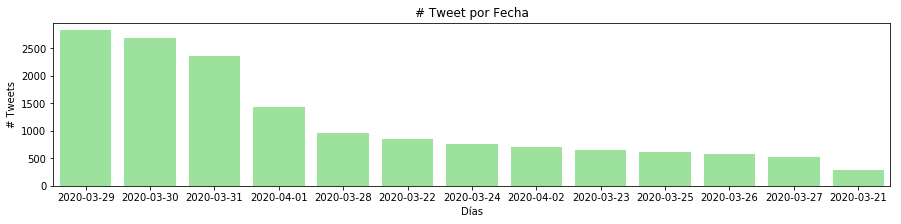

In [4]:
plt.figure(figsize=(15,3))
sns.barplot(x=base.Date.dt.date.value_counts().index, y=base.Date.dt.date.value_counts(), color = 'lightgreen')
plt.title("# Tweet por Fecha")
plt.xlabel("Días")
plt.ylabel("# Tweets")
plt.show()

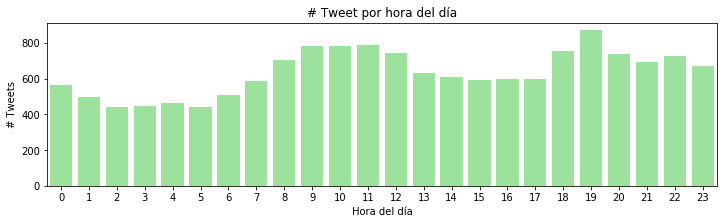

In [5]:
plt.figure(figsize=(12,3))
sns.barplot(x=base['Date'].dt.hour.value_counts().index, y=base['Date'].dt.hour.value_counts(), color = 'lightgreen')
plt.title("# Tweet por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("# Tweets")
plt.show()

In [6]:
base['Date'].dt.weekday.value_counts().index

Int64Index([6, 0, 1, 2, 3, 5, 4], dtype='int64')

In [7]:
import calendar
calendar.day_name[6]

'Sunday'

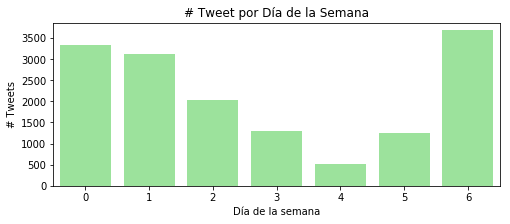

In [8]:
plt.figure(figsize=(8,3))
sns.barplot(x=base['Date'].dt.weekday.value_counts().index, y=base['Date'].dt.weekday.value_counts(), color = 'lightgreen')
plt.title("# Tweet por Día de la Semana")
plt.xlabel("Día de la semana")
plt.ylabel("# Tweets")
plt.show()

In [9]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
import string
from nltk.stem import WordNetLemmatizer


def remove_in_words(lista_textos):
    ### input: lista de textos
    ### retorna una nueva lista eliminando puntuacion y numeros de las letras
    punct = list(string.punctuation)
    texto_total = []
    for parrafos in lista_textos:
        parrafo = []
        for palabra in parrafos.split():
            palabras = []
            for letra in palabra.lower():
                if letra not in punct and not letra.isnumeric():
                    palabras.append(letra)
            palabras = ''.join(palabras)
            parrafo.append(palabras)
        parrafo = ' '.join(parrafo)
        texto_total.append(parrafo)
    return texto_total


def pre_process(lista_corpus):
    ### input: lista de textos
    ### retorna una nueva lista eliminando stopwords, numeros y puntuacion de las palabras
    stopset = stopwords.words('spanish') + list(string.punctuation)
    parrafos_list = []
    for corp in lista_corpus:
        corpus = corp.lower()
        corpus = " ".join([i for i in word_tokenize(corpus) if i not in stopset and not i.isnumeric() and len(i) > 2])
        corpus = unidecode(corpus)
        parrafos_list.append(corpus)
    return parrafos_list 

def lemm(lista_corpus):
    ### input: lista de textos
    ### retorna una nueva lista lematizada por adjetivo, adverbio, pronombre, verbo
    lmt = WordNetLemmatizer()
    parrafos = []
    for corp in lista_corpus:
        texto = []
        for word in corp.split():
            lema = word.lower()
            for i in list(['v','a','r','n','s']):
                lema = lmt.lemmatize(lema, pos=i)
            texto.append(lema)
        texto = ' '.join(texto)
        parrafos.append(texto)
    return parrafos

### Limpieza de Datos

In [10]:
tweets = base['Tweet Text']

parrafos_list = remove_in_words(tweets)
parrafos_list = pre_process(parrafos_list)
parrafos_list = lemm(parrafos_list)

In [11]:
base['Tweet_Limpio'] = parrafos_list

In [12]:
base.head(3)

,Date,Screen Name,Full Name,Tweet Text,Tweet ID,Link(s),Media,Location,Retweets,Favorites,...,Follows,Listed,Verfied,User Since,Location.1,Bio,Website,Timezone,Profile Image,Tweet_Limpio
0,2020-04-02 20:33:38,@NeoMoncadaC,NeoMoncadaC,🤔 #elchicodelagorra #enmicasa #quedateencasa #...,1245887151134461954,https://www.instagram.com/p/B-gBvZDBURn/?igshi...,NaN,NaN,0,0,...,1527,3,NaN,2009-12-04 04:14:07,Bogotá - Colombia,"Soy Músico, Un Loco, Cantante De Ducha, Batero...",https://www.instagram.com/NeoMoncadaC,NaN,View,elchicodelagorra enmicasa quedateencasa lada c...
1,2020-04-02 20:32:13,@ComoRueda,Rueda Como Niña,¿Y usted qué opina de las #CiclovíasTemporales...,1245886794488479746,https://twitter.com/streetmix/status/124583252...,pic.twitter.com/b78c7vICbj,NaN,0,0,...,813,1,NaN,2018-09-03 20:47:54,"Bogotá, D.C., Colombia",#RuedaComoNiña org de mujeres #ciclistas y edu...,NaN,NaN,View,usted opina cicloviastemporales bogota streetm...
2,2020-04-02 20:30:32,@ColmundoRadio,Colmundo Radio,#Bogotá La alcaldesa de Bogotá @ClaudiaLopez S...,1245886370855485440,NaN,pic.twitter.com/h3SFKkOtIj,NaN,0,0,...,1110,257,NaN,2010-01-07 13:53:25,Colombia,"Colmundo Cambia. #Acércate a las regiones, a l...",http://www.colmundoradio.com.co,NaN,View,bogota alcaldesa bogota claudialopez manifesto...


### Creación de Características

- Crear columna con solo hashtags

In [13]:
import re

hashtags = []
for tweet in base['Tweet Text'].to_list():
    hashtags.append(re.findall(r"#(\w+)", tweet))

In [14]:
base['Tweet Text'].iloc[4]

'#Bogota #ConsumeLocal Apoyemos a las PYMES 👍🏼 RT @buendia_macond: Amig@s, me encuentro en una situación económica muy difícil, vivo en Bogotá y tengo una tienda de frutos secos, semillas y snacks saludables (maní, nuez, almendras, quinoa etc...) cualquier cosa que necesiten estoy a su orden por medio de domicilios. Les agradecería mucho un Rt.'

In [15]:
hashtag_str_list = []

for hashtag in hashtags:
    hashtag_str_list.append(' '.join(hashtag))

In [16]:
base['hashtags'] = hashtag_str_list
base.head(3)

,Date,Screen Name,Full Name,Tweet Text,Tweet ID,Link(s),Media,Location,Retweets,Favorites,...,Listed,Verfied,User Since,Location.1,Bio,Website,Timezone,Profile Image,Tweet_Limpio,hashtags
0,2020-04-02 20:33:38,@NeoMoncadaC,NeoMoncadaC,🤔 #elchicodelagorra #enmicasa #quedateencasa #...,1245887151134461954,https://www.instagram.com/p/B-gBvZDBURn/?igshi...,NaN,NaN,0,0,...,3,NaN,2009-12-04 04:14:07,Bogotá - Colombia,"Soy Músico, Un Loco, Cantante De Ducha, Batero...",https://www.instagram.com/NeoMoncadaC,NaN,View,elchicodelagorra enmicasa quedateencasa lada c...,elchicodelagorra enmicasa quedateencasa lada21...
1,2020-04-02 20:32:13,@ComoRueda,Rueda Como Niña,¿Y usted qué opina de las #CiclovíasTemporales...,1245886794488479746,https://twitter.com/streetmix/status/124583252...,pic.twitter.com/b78c7vICbj,NaN,0,0,...,1,NaN,2018-09-03 20:47:54,"Bogotá, D.C., Colombia",#RuedaComoNiña org de mujeres #ciclistas y edu...,NaN,NaN,View,usted opina cicloviastemporales bogota streetm...,CiclovíasTemporales Bogotá
2,2020-04-02 20:30:32,@ColmundoRadio,Colmundo Radio,#Bogotá La alcaldesa de Bogotá @ClaudiaLopez S...,1245886370855485440,NaN,pic.twitter.com/h3SFKkOtIj,NaN,0,0,...,257,NaN,2010-01-07 13:53:25,Colombia,"Colmundo Cambia. #Acércate a las regiones, a l...",http://www.colmundoradio.com.co,NaN,View,bogota alcaldesa bogota claudialopez manifesto...,Bogotá


In [17]:
def count_words(text):
    return len(text.split(' '))

In [18]:
base['n_hashtags'] = base['hashtags'].apply(count_words)

In [20]:
black_list = ['bogota', 'codvid', 'covid', 'quedateencasa', 'colombia', 'cuarentena', 'coronavirus']

In [21]:
def remove_hashtag(tweet, hashtags):
    
    hashtags_list = hashtags.lower().split(' ')
    
    tweet_list = tweet.lower().split(' ')
    
    for word in tweet_list:
        if word in hashtags_list:
            tweet_list.remove(word)
            
    return ' '.join(tweet_list)

In [22]:
def remove_black_list(tweet, black_list = black_list):
        
    tweet_list = tweet.lower().split(' ')
    
    for word in tweet_list:
        if word in black_list:
            tweet_list.remove(word)
            
    return ' '.join(tweet_list)

In [23]:
base['Tweet_no_hash'] = base.apply(lambda x: remove_hashtag(x['Tweet_Limpio'], x['hashtags']), axis=1)

In [24]:
base['Tweet_Limpio2'] = base['Tweet_no_hash'].apply(remove_black_list)

In [25]:
base.head(3)

,Date,Screen Name,Full Name,Tweet Text,Tweet ID,Link(s),Media,Location,Retweets,Favorites,...,Location.1,Bio,Website,Timezone,Profile Image,Tweet_Limpio,hashtags,n_hashtags,Tweet_no_hash,Tweet_Limpio2
0,2020-04-02 20:33:38,@NeoMoncadaC,NeoMoncadaC,🤔 #elchicodelagorra #enmicasa #quedateencasa #...,1245887151134461954,https://www.instagram.com/p/B-gBvZDBURn/?igshi...,NaN,NaN,0,0,...,Bogotá - Colombia,"Soy Músico, Un Loco, Cantante De Ducha, Batero...",https://www.instagram.com/NeoMoncadaC,NaN,View,elchicodelagorra enmicasa quedateencasa lada c...,elchicodelagorra enmicasa quedateencasa lada21...,11,enmicasa lada bogota amoreterno amor,enmicasa lada amoreterno amor
1,2020-04-02 20:32:13,@ComoRueda,Rueda Como Niña,¿Y usted qué opina de las #CiclovíasTemporales...,1245886794488479746,https://twitter.com/streetmix/status/124583252...,pic.twitter.com/b78c7vICbj,NaN,0,0,...,"Bogotá, D.C., Colombia",#RuedaComoNiña org de mujeres #ciclistas y edu...,NaN,NaN,View,usted opina cicloviastemporales bogota streetm...,CiclovíasTemporales Bogotá,2,usted opina cicloviastemporales bogota streetm...,usted opina cicloviastemporales streetmix new ...
2,2020-04-02 20:30:32,@ColmundoRadio,Colmundo Radio,#Bogotá La alcaldesa de Bogotá @ClaudiaLopez S...,1245886370855485440,NaN,pic.twitter.com/h3SFKkOtIj,NaN,0,0,...,Colombia,"Colmundo Cambia. #Acércate a las regiones, a l...",http://www.colmundoradio.com.co,NaN,View,bogota alcaldesa bogota claudialopez manifesto...,Bogotá,1,bogota alcaldesa bogota claudialopez manifesto...,alcaldesa claudialopez manifesto gobierno naci...


In [26]:
positivas = pd.read_csv('positivas.txt', names = ['word'])['word'].to_list()
negativas = pd.read_csv('negativa.txt', names = ['word'])['word'].to_list()

In [27]:
def check_positive_words(text):
    counter = 0
    
    for word in text.split(' '):
        if word in positivas:
            counter += 1
            
    return counter

In [28]:
def check_negative_words(text):
    counter = 0
    
    for word in text.split(' '):
        if word in negativas:
            counter += 1
            
    return counter

In [29]:
base['n_positivas'] = base['Tweet_Limpio2'].apply(check_positive_words)
base['n_negativas'] = base['Tweet_Limpio2'].apply(check_negative_words)

In [30]:
base.head(3)

,Date,Screen Name,Full Name,Tweet Text,Tweet ID,Link(s),Media,Location,Retweets,Favorites,...,Website,Timezone,Profile Image,Tweet_Limpio,hashtags,n_hashtags,Tweet_no_hash,Tweet_Limpio2,n_positivas,n_negativas
0,2020-04-02 20:33:38,@NeoMoncadaC,NeoMoncadaC,🤔 #elchicodelagorra #enmicasa #quedateencasa #...,1245887151134461954,https://www.instagram.com/p/B-gBvZDBURn/?igshi...,NaN,NaN,0,0,...,https://www.instagram.com/NeoMoncadaC,NaN,View,elchicodelagorra enmicasa quedateencasa lada c...,elchicodelagorra enmicasa quedateencasa lada21...,11,enmicasa lada bogota amoreterno amor,enmicasa lada amoreterno amor,1,0
1,2020-04-02 20:32:13,@ComoRueda,Rueda Como Niña,¿Y usted qué opina de las #CiclovíasTemporales...,1245886794488479746,https://twitter.com/streetmix/status/124583252...,pic.twitter.com/b78c7vICbj,NaN,0,0,...,NaN,NaN,View,usted opina cicloviastemporales bogota streetm...,CiclovíasTemporales Bogotá,2,usted opina cicloviastemporales bogota streetm...,usted opina cicloviastemporales streetmix new ...,0,0
2,2020-04-02 20:30:32,@ColmundoRadio,Colmundo Radio,#Bogotá La alcaldesa de Bogotá @ClaudiaLopez S...,1245886370855485440,NaN,pic.twitter.com/h3SFKkOtIj,NaN,0,0,...,http://www.colmundoradio.com.co,NaN,View,bogota alcaldesa bogota claudialopez manifesto...,Bogotá,1,bogota alcaldesa bogota claudialopez manifesto...,alcaldesa claudialopez manifesto gobierno naci...,2,0


In [33]:
base[base['n_positivas'] > 3]['Tweet Text'][0:5]

156    El Secretario de Hacienda de #Bogotá @JuanMRam...
388    Índice de calidad del aire: #Bogotá: 34 Bueno ...
424    #Medellín, #Bogotá, #Cali y #Bucaramanga, resp...
624    #BOGOTÁ🥰 #QuedateEnCasa RT @Bogota__DC: Bogotá...
740    Y usted señora alcaldesa, actuando como rueda ...
Name: Tweet Text, dtype: object

In [34]:
base[base['n_negativas'] > 3]['Tweet Text'][0:5]

28     #Bogota RT @Juan_Florez: Qué bofetada a Bogotá...
80     #Bogota la bipolaridad de Claudia Lopez. ⬇️ RT...
99     En el primer día de aislamiento preventivo obl...
101    En el primer día de aislamiento preventivo obl...
156    El Secretario de Hacienda de #Bogotá @JuanMRam...
Name: Tweet Text, dtype: object

In [35]:
todas_las_palabras = []
for tweet in base['Tweet_Limpio2']:
    for palabra in tweet.split(' '):
        todas_las_palabras.append(palabra)

In [36]:
df = pd.DataFrame(data= todas_las_palabras, columns = ['word'])

In [37]:
df.to_csv('validar.csv', index = False)

### Vectorización

- Entrenar vectores (Hashtag2Vec)

In [38]:
hash_model = Word2Vec(hashtags, size=50, window=10, min_count=1, workers=4)
hash_model.save("hash2vec.model")

In [39]:
hash_vectors = hash_model.wv

In [40]:
len(hash_vectors.wv.vocab)

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


12412

In [41]:
hash_vectors.most_similar("Coronavirus") 

[('Venezuela', 0.999652087688446),
 ('Colombia', 0.999468207359314),
 ('BogotaSeQuedaEnCasa', 0.9994301199913025),
 ('Bogota', 0.999305248260498),
 ('SanaDistancia', 0.9992607235908508),
 ('COVID', 0.9992529153823853),
 ('bienestar', 0.9992161989212036),
 ('streetarteverywhere', 0.9991912245750427),
 ('Love', 0.999183714389801),
 ('Italia', 0.9991384744644165)]

In [42]:
import csv

with open('hash_embeddings.tsv', 'w', encoding = 'utf-8') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    words = hash_model.wv.vocab.keys()
    for word in words:
        vector = hash_model.wv.get_vector(word).tolist()
        row = [word] + vector
        writer.writerow(row)
        

In [67]:
import os

words = '\n'.join(list(hash_model.wv.vocab.keys()))

with open(os.path.join('hash_metadata.tsv'), 'w', encoding = 'utf-8') as f:
    f.write(words)

- Entrenar Word2Vec

In [44]:
list_of_lists = []

for tweet in parrafos_list:
    list_of_lists.append(tweet.split(' '))

In [45]:
words_model = Word2Vec(list_of_lists, size=30, window=10, min_count=1, workers=4)
words_model.save("words2vec.model")

In [46]:
len(words_model.wv.vocab)

40949

In [47]:
words_model.wv.most_similar('panama')

[('peru', 0.9996012449264526),
 ('argentina', 0.999327540397644),
 ('venezuela', 0.9991635084152222),
 ('mexico', 0.9986045360565186),
 ('brasil', 0.9985734820365906),
 ('ecuador', 0.9985310435295105),
 ('chile', 0.9984887838363647),
 ('mar', 0.9981499314308167),
 ('ibiza', 0.9977920651435852),
 ('valencia', 0.9974241256713867)]

In [48]:
import csv

with open('words_embeddings.tsv', 'w', encoding = 'utf-8') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    words = words_model.wv.vocab.keys()
    for word in words:
        vector = words_model.wv.get_vector(word).tolist()
        row = [word] + vector
        writer.writerow(row)

In [49]:
import os

words = '\n'.join(list(words_model.wv.vocab.keys()))

with open(os.path.join('words_metadata.tsv'), 'w', encoding = 'utf-8') as f:
    f.write(words)

- Entrenando Tweets2Vec

In [50]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set =set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # 
    # Loop through each reviews
    for review in reviews:
         # Print a status message every 1000th review
#         if counter%100. == 0.:
#             print ("Review %d of %d" % (counter, len(reviews))
       
       # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)

        counter = counter + 1
        
    return reviewFeatureVecs

In [51]:
trainDataVecs = getAvgFeatureVecs(list_of_lists, words_model, 30)

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [52]:
trainDataVecs[0]

array([ 1.4629614e-03,  6.1389077e-01, -4.4433033e-01,  5.0326842e-01,
       -4.8130810e-02,  7.6679611e-01, -1.1858411e+00,  2.7332929e-01,
       -4.0495014e-01,  1.2220697e+00, -1.6615622e-01,  2.8396311e+00,
        9.9352437e-01,  1.4478286e-03, -1.2733246e+00,  1.7013347e+00,
        2.8380817e-01,  4.1204259e-01, -5.5565363e-01, -4.4082391e-01,
       -2.0268912e+00, -3.3161202e-01,  1.6628435e-01, -3.3151429e-02,
       -1.2024873e+00,  7.3387629e-01,  3.6858207e-01, -5.0567621e-01,
        3.0510271e-01,  2.3501144e-01], dtype=float32)

In [53]:
tweets = base['Tweet Text']

In [54]:
import csv

with open('Tweets2Vec_embeddings.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')

    counter = 0
    for vector, tweet in zip(trainDataVecs, tweets):
        counter = counter + 1
        row = [counter] + vector
        writer.writerow(row)

In [55]:
import os

words = '\n'.join(tweets.to_list())

with open(os.path.join('Tweets2Vec_metadata.tsv'), 'w', encoding = 'utf-8') as f:
    f.write(words) 

In [56]:
col_names = []

for i in range(1,31):
    col_names.append('D' + str(i))
 
tweets2vec = pd.DataFrame(data=trainDataVecs, columns = col_names)
tweets2vec.head(3)

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30
0,0.001463,0.613891,-0.444330,0.503268,-0.048131,0.766796,-1.185841,0.273329,-0.404950,1.222070,...,-2.026891,-0.331612,0.166284,-0.033151,-1.202487,0.733876,0.368582,-0.505676,0.305103,0.235011
1,0.046550,0.306767,-0.191082,0.181748,0.048017,0.389730,-0.474484,0.124301,-0.267471,0.638837,...,-0.904239,-0.030180,0.045263,0.057230,-0.549017,0.315864,0.137462,-0.336828,0.172468,0.116095
2,0.155120,1.181347,-0.624883,0.633665,0.074375,1.349668,-1.544807,0.421500,-1.028911,1.948070,...,-3.263953,-0.186551,-0.042247,0.172017,-1.863397,1.035453,0.400133,-1.156771,0.664792,0.530952


### Reducción de dimensiones y Agrupación

- PCA

In [57]:
from sklearn.decomposition import PCA

In [58]:
len(tweets2vec)

15221

In [59]:
pca = PCA(n_components=3)

PCs = pca.fit_transform(tweets2vec)
PC_Df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2', 'PC3'])

In [60]:
pca.explained_variance_ratio_

array([0.9263157 , 0.05060847, 0.01378879])

In [62]:
PC_Df.head(3)

,PC1,PC2,PC3
0,-0.242683,0.233543,0.120343
1,-2.877405,0.105023,0.078621
2,2.855597,-1.038114,-0.115673


- Clusters (K Means)

In [64]:
from sklearn.cluster import KMeans

In [65]:
kmeans = KMeans(n_clusters=10, random_state=0)

clusters = kmeans.fit(PC_Df)

In [66]:
PC_Df['Cluster_id'] = kmeans.labels_

In [67]:
PC_Df.head(3)

,PC1,PC2,PC3,Cluster_id
0,-0.242683,0.233543,0.120343,9
1,-2.877405,0.105023,0.078621,5
2,2.855597,-1.038114,-0.115673,4


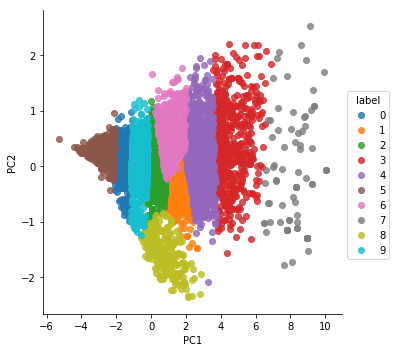

In [68]:
#plot data with seaborn (don't add a legend yet)
facet = sns.lmplot(data=PC_Df, x='PC1', y='PC2', hue='Cluster_id', 
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)


In [69]:
PC_Df['Cluster_id'].value_counts().index

Int64Index([9, 2, 0, 5, 1, 6, 4, 3, 8, 7], dtype='int64')

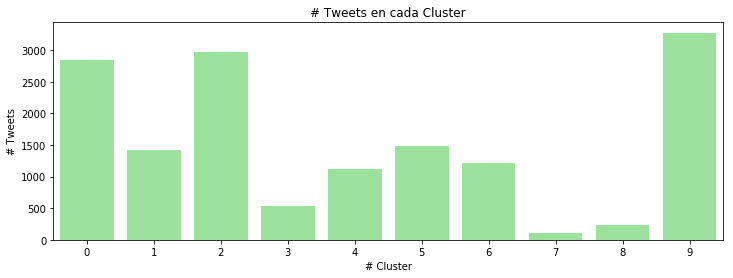

In [70]:
plt.figure(figsize=(12,4))
sns.barplot(x=PC_Df['Cluster_id'].value_counts().index, y=PC_Df['Cluster_id'].value_counts(), color = 'lightgreen')
plt.title("# Tweets en cada Cluster")
plt.xlabel("# Cluster")
plt.ylabel("# Tweets")
plt.show()

In [71]:
base2 = base.merge(right = PC_Df, left_index = True, right_index = True)
base2.head(3)

,Date,Screen Name,Full Name,Tweet Text,Tweet ID,Link(s),Media,Location,Retweets,Favorites,...,hashtags,n_hashtags,Tweet_no_hash,Tweet_Limpio2,n_positivas,n_negativas,PC1,PC2,PC3,Cluster_id
0,2020-04-02 20:33:38,@NeoMoncadaC,NeoMoncadaC,🤔 #elchicodelagorra #enmicasa #quedateencasa #...,1245887151134461954,https://www.instagram.com/p/B-gBvZDBURn/?igshi...,NaN,NaN,0,0,...,elchicodelagorra enmicasa quedateencasa lada21...,11,enmicasa lada bogota amoreterno amor,enmicasa lada amoreterno amor,1,0,-0.242683,0.233543,0.120343,9
1,2020-04-02 20:32:13,@ComoRueda,Rueda Como Niña,¿Y usted qué opina de las #CiclovíasTemporales...,1245886794488479746,https://twitter.com/streetmix/status/124583252...,pic.twitter.com/b78c7vICbj,NaN,0,0,...,CiclovíasTemporales Bogotá,2,usted opina cicloviastemporales bogota streetm...,usted opina cicloviastemporales streetmix new ...,0,0,-2.877405,0.105023,0.078621,5
2,2020-04-02 20:30:32,@ColmundoRadio,Colmundo Radio,#Bogotá La alcaldesa de Bogotá @ClaudiaLopez S...,1245886370855485440,NaN,pic.twitter.com/h3SFKkOtIj,NaN,0,0,...,Bogotá,1,bogota alcaldesa bogota claudialopez manifesto...,alcaldesa claudialopez manifesto gobierno naci...,2,0,2.855597,-1.038114,-0.115673,4


In [72]:
base2.columns

Index(['Date', 'Screen Name', 'Full Name', 'Tweet Text', 'Tweet ID', 'Link(s)',
       'Media', 'Location', 'Retweets', 'Favorites', 'App', 'Followers',
       'Follows', 'Listed', 'Verfied', 'User Since', 'Location.1', 'Bio',
       'Website', 'Timezone', 'Profile Image', 'Tweet_Limpio', 'hashtags',
       'n_hashtags', 'Tweet_no_hash', 'Tweet_Limpio2', 'n_positivas',
       'n_negativas', 'PC1', 'PC2', 'PC3', 'Cluster_id'],
      dtype='object')

In [76]:
from collections import Counter 
import numpy as np
from PIL import Image
from urllib.request import urlopen
from wordcloud import WordCloud, ImageColorGenerator
from stop_words import get_stop_words
import matplotlib.pyplot as plt
%matplotlib inline

def get_bar_chart(dict_to_display, title):
    top_50_words = dict(Counter(dict_to_display).most_common(50))
    plt.figure(figsize=(12,3))
    plt.bar(range(len(top_50_words)), list(top_50_words.values()), align='center')
    plt.xticks(range(len(top_50_words)), list(top_50_words.keys()),rotation=90)
    plt.xlabel("Palabra")
    plt.ylabel("Cantidad de palabras")
    plt.title('{}'.format(title))
    plt.show()
    
def get_word_cloud(dict_to_display, title):
    top_50_words = dict(Counter(dict_to_display).most_common(50))
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(top_50_words)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('{}'.format(title))
    plt.show()

In [161]:
def mostrar_cluster(cluster):
    
    cluster_list1 = base2[base2['Cluster_id'] == cluster]

#     cluster_list2 = cluster_list1['Tweet_Limpio'].to_list()
#     cluster_list2 = cluster_list1['hashtags'].to_list()   
    cluster_list2 = cluster_list1['Tweet_Limpio2'].to_list()   
    
    
    lista_palabras = []

    for element in cluster_list2:
        for palabra in element.split(' '):
            lista_palabras.append(palabra)

    frecuencias={}
    for palabra in lista_palabras:
        if palabra in frecuencias:
            frecuencias[palabra]+=1
        else:
            frecuencias[palabra]=1

    get_bar_chart(dict_to_display = frecuencias, title = 'Cluster # {}'.format(cluster))
    get_word_cloud(dict_to_display = frecuencias, title = 'Cluster # {}'.format(cluster))

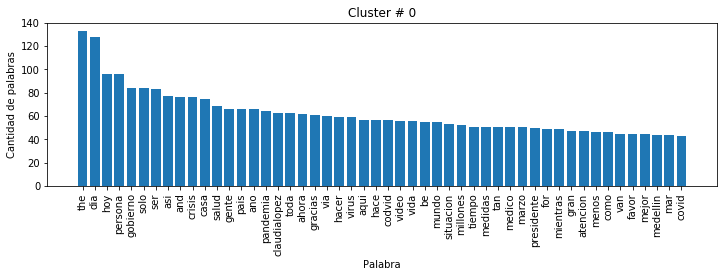

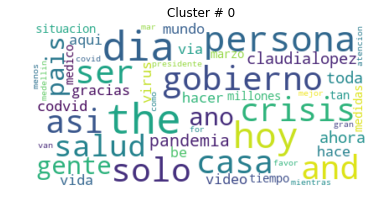

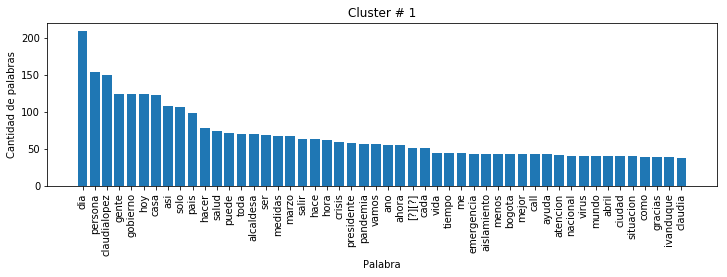

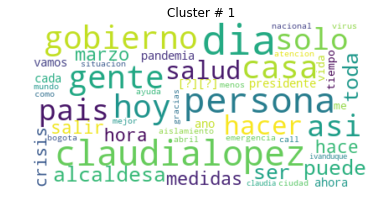

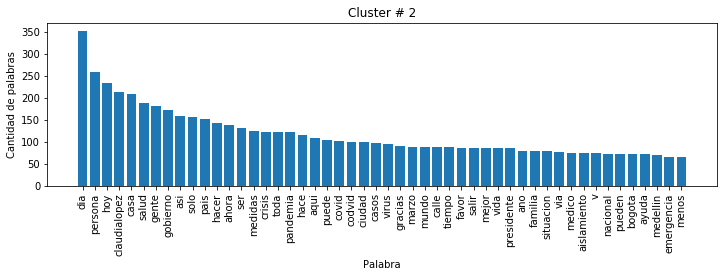

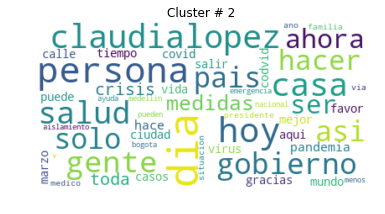

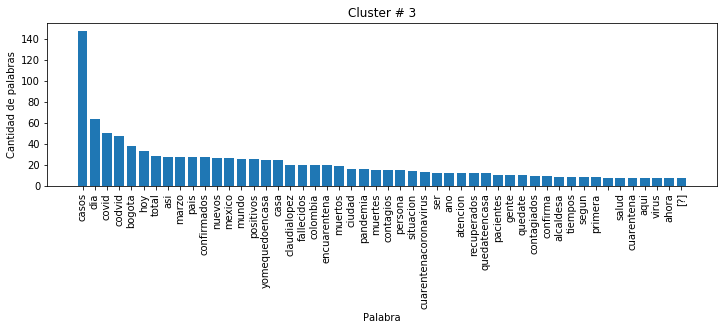

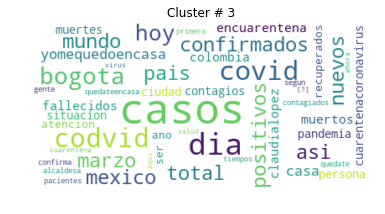

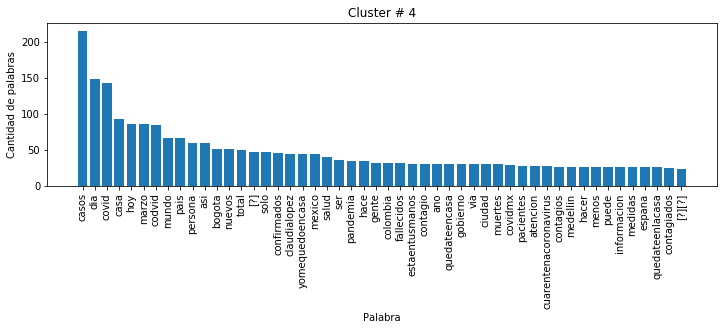

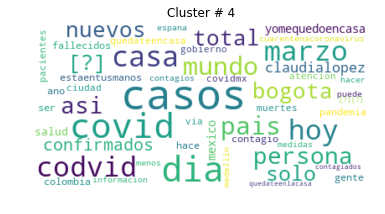

In [162]:
for i in range(0, 5):
    mostrar_cluster(i)

### Métodos Supervisados

- Predecir Tweets Positivos y Negativos

In [79]:
base2.head(3)

,Date,Screen Name,Full Name,Tweet Text,Tweet ID,Link(s),Media,Location,Retweets,Favorites,...,hashtags,n_hashtags,Tweet_no_hash,Tweet_Limpio2,n_positivas,n_negativas,PC1,PC2,PC3,Cluster_id
0,2020-04-02 20:33:38,@NeoMoncadaC,NeoMoncadaC,🤔 #elchicodelagorra #enmicasa #quedateencasa #...,1245887151134461954,https://www.instagram.com/p/B-gBvZDBURn/?igshi...,NaN,NaN,0,0,...,elchicodelagorra enmicasa quedateencasa lada21...,11,enmicasa lada bogota amoreterno amor,enmicasa lada amoreterno amor,1,0,-0.242683,0.233543,0.120343,9
1,2020-04-02 20:32:13,@ComoRueda,Rueda Como Niña,¿Y usted qué opina de las #CiclovíasTemporales...,1245886794488479746,https://twitter.com/streetmix/status/124583252...,pic.twitter.com/b78c7vICbj,NaN,0,0,...,CiclovíasTemporales Bogotá,2,usted opina cicloviastemporales bogota streetm...,usted opina cicloviastemporales streetmix new ...,0,0,-2.877405,0.105023,0.078621,5
2,2020-04-02 20:30:32,@ColmundoRadio,Colmundo Radio,#Bogotá La alcaldesa de Bogotá @ClaudiaLopez S...,1245886370855485440,NaN,pic.twitter.com/h3SFKkOtIj,NaN,0,0,...,Bogotá,1,bogota alcaldesa bogota claudialopez manifesto...,alcaldesa claudialopez manifesto gobierno naci...,2,0,2.855597,-1.038114,-0.115673,4


In [167]:
base2.columns

Index(['Date', 'Screen Name', 'Full Name', 'Tweet Text', 'Tweet ID', 'Link(s)',
       'Media', 'Location', 'Retweets', 'Favorites', 'App', 'Followers',
       'Follows', 'Listed', 'Verfied', 'User Since', 'Location.1', 'Bio',
       'Website', 'Timezone', 'Profile Image', 'Tweet_Limpio', 'hashtags',
       'n_hashtags', 'Tweet_no_hash', 'Tweet_Limpio2', 'n_positivas',
       'n_negativas', 'PC1', 'PC2', 'PC3', 'Cluster_id', 'target_pos',
       'target_neg'],
      dtype='object')

In [166]:
base_final = base2[['Tweet ID', 'hashtags', 'n_hashtags', 'Tweet_no_hash', 'Tweet_Limpio2', 'n_positivas', 'n_negativas', 'PC1', 'PC2', 'PC3', 'Cluster_id']]
base_final.head(3)
base_final.to_csv('base_final.csv', index = False)

In [84]:
base2['target_pos'] = [1 if x >= 3 else 0 for x in base2['n_positivas']]
base2['target_neg'] = [1 if x >= 3 else 0 for x in base2['n_negativas']]

In [87]:
base2.target_neg.value_counts()

0    13181
1     2040
Name: target_neg, dtype: int64

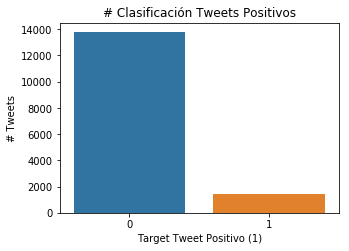

In [95]:
plt.figure(figsize=(5,3.5))
sns.barplot(x=base2.target_pos.value_counts().index, y=base2.target_pos.value_counts())
plt.title("# Clasificación Tweets Positivos")
plt.xlabel("Target Tweet Positivo (1)")
plt.ylabel("# Tweets")
plt.show()

In [97]:
from sklearn.model_selection import train_test_split

In [148]:
X_train, X_test, y_train, y_test = train_test_split(base2['Tweet_Limpio2'], base2['target_pos'], test_size=0.30, random_state=8)

In [149]:
print('Tamaño data entrenamiento: ', len(X_train))
print('Tamaño data prueba: ', len(X_test))

Tamaño data entrenamiento:  10654
Tamaño data prueba:  4567


In [150]:
y_test.value_counts()

0    4158
1     409
Name: target_pos, dtype: int64

In [151]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [153]:
def get_accuracy_score(labels_test, predicciones):
    print("The test accuracy is: ")
    return print(accuracy_score(labels_test, predicciones))
    
def get_classification_report(labels_test, predicciones):
    print("Classification report")
    return print(classification_report(labels_test,predicciones))
    
def get_confusion_matrix(labels_test, predicciones):
    cm = metrics.confusion_matrix(labels_test, predicciones)
    
#     aux_df = df3[['Etiqueta', 'CodeCat']].drop_duplicates().sort_values('CodeCat')

    plt.figure(figsize=(8, 8))
    
    sns.heatmap(cm,
                annot=True,
#                 xticklabels=aux_df['Etiqueta'].values, 
#                 yticklabels=aux_df['Etiqueta'].values,
                fmt=".0f",
                linewidths=.5,
                square = True,
                cmap = 'Blues'
               );

    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(labels_test, predicciones))
    plt.title(all_sample_title, size = 10);
    
def get_confusion_matrix2(labels_test, predicciones):
    cm = metrics.confusion_matrix(labels_test, predicciones)
    
#     aux_df = df3[['Etiqueta', 'CodeCat']].drop_duplicates().sort_values('CodeCat')

    plt.figure(figsize=(8, 8))
    
    sns.heatmap(cm,
                annot=True,
#                 xticklabels=aux_df['Etiqueta'].values, 
#                 yticklabels=aux_df['Etiqueta'].values,
                fmt=".0f",
                linewidths=.5,
                square = True,
                cmap = 'YlGnBu'
               );

    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(labels_test, predicciones))
    plt.title(all_sample_title, size = 10);

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding='utf-8',
                        stop_words=None,
                        lowercase=False,
                        ngram_range = (1,2),
                        max_df=10,
                        min_df=1,
                        max_features=50,
                        norm='l1',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(10654, 50)
(4567, 50)


In [155]:
len(features_train)

10654

In [156]:
from sklearn.linear_model import LogisticRegression

mlrc =LogisticRegression(random_state = 8)
mlrc.fit(features_train, labels_train)
mlrc_pred = mlrc.predict(features_test)

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The test accuracy is: 
0.9115393037004598
Classification report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      4158
           1       0.78      0.02      0.03       409

    accuracy                           0.91      4567
   macro avg       0.84      0.51      0.49      4567
weighted avg       0.90      0.91      0.87      4567



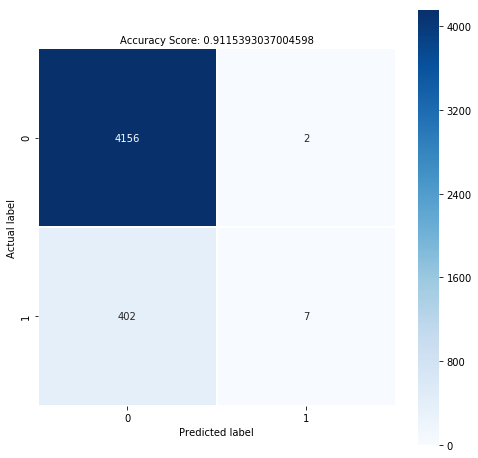

In [157]:
get_accuracy_score(labels_test, mlrc_pred)
get_classification_report(labels_test, mlrc_pred)
get_confusion_matrix(labels_test, mlrc_pred)

In [160]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

RSEED = 50
# Create the model with 100 trees
rf = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

rf.fit(features_train, labels_train)
rf_pred = rf.predict(features_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


The test accuracy is: 
0.9126341142982264
Classification report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      4158
           1       0.78      0.03      0.07       409

    accuracy                           0.91      4567
   macro avg       0.85      0.52      0.51      4567
weighted avg       0.90      0.91      0.87      4567



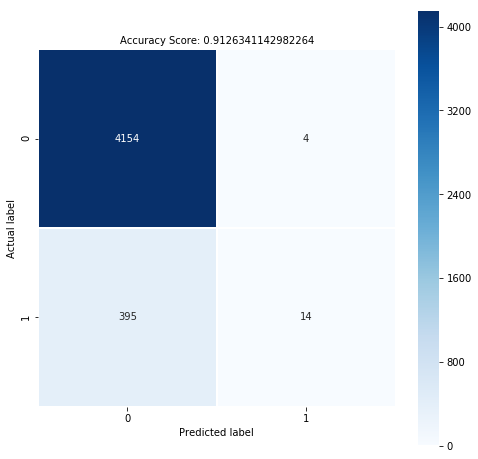

In [159]:
get_accuracy_score(labels_test, rf_pred)
get_classification_report(labels_test, rf_pred)
get_confusion_matrix(labels_test, rf_pred)